In [2]:
import pandas as pd
data = pd.read_csv('/fire_data.csv')
#data = pd.read_csv('/Users/maggiehuang/Desktop/INSY662_Data_Mining_and_Visualization_for_Analytic/INSY662-Data-Mining-and-Visualization-Project/Fire_Incidents_Data.csv')

<ipython-input-2-b5c4a7dcacb5>:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/fire_data.csv')


In [3]:
data

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,3462493,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0
1,3462494,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0
2,3462495,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0
3,3462496,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0
4,3462497,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32924,3495417,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,NaN,0.0,0.0,0.0,0.0,2023-01-01T07:29:02,...,98 - Not applicable: Alarm operated OR presenc...,4 - Interconnected,3 - No one (at risk) evacuated as a result of ...,3 - Spread to entire room of origin,4 - Other reason for non activation/operation,1 - Full sprinkler system present,1 - Fire extinguished prior to arrival,2023-01-01T07:21:18,2023-01-01T07:26:30,0.0
32925,3495418,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),NaN,0.0,3000.0,0.0,0.0,2023-01-01T10:57:07,...,"5 - Separated from fire (e.g. wall, etc)",4 - Interconnected,7 - Not applicable: Occupant(s) first alerted ...,9 - Confined to roof/exterior structure,8 - Not applicable - no sprinkler system present,3 - No sprinkler system,4 - Flames showing from small area (one storey...,2023-01-01T10:48:10,2023-01-01T10:51:37,0.0
32926,3495419,24 - Cooking Area or Kitchen,01 - Normal (no change),8 - Not applicable (not a business),NaN,0.0,1000.0,0.0,0.0,2023-01-01T12:28:05,...,98 - Not applicable: Alarm operated OR presenc...,1 - Battery operated,2 - Some persons (at risk) self evacuated as a...,"4 - Spread beyond room of origin, same floor",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,1 - Fire extinguished prior to arrival,2023-01-01T12:22:14,2023-01-01T12:27:04,0.0
32927,3495420,99 - Undetermined (formerly 98),NaN,NaN,NaN,0.0,5000.0,NaN,0.0,2023-01-01T13:17:38,...,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,2023-01-01T12:58:07,2023-01-01T13:04:24,0.0


# 1. Drop and combine some columns

In [4]:
#drop the columns 'id', 'Incident_Number' and 'Level_Of_Origin' since they're just identifiers
#drop 'Exposures' since it has too many missing values
#drop 'Number_of_responding_apparatus' bc it's almost perfectly collinear with 'Number_of_responding_personnel'
#drop 'Sprinkler_System_Presence' since we already have ''Sprinkler_System_Operation'
#drop 'Fire_Alarm_System_Operation' and 'Fire_Alarm_System_Presence'; only keep 'Fire_Alarm_System_Impact_on_Evacuation'
#drop 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type' and only keep 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation'
data_dropped = data.drop(columns=['_id', 'Incident_Number', 'Level_Of_Origin', 'Exposures', 'Number_of_responding_apparatus', 'Sprinkler_System_Presence', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type', ], errors='ignore')

#make sure these columns have int objects since the original dataset is having some data quality issues
int_columns = [
    'Incident_Station_Area',
    'Civilian_Casualties',
    'Count_of_Persons_Rescued',
    'Incident_Ward',
    'Number_of_responding_personnel',
    'TFS_Firefighter_Casualties',
    'Estimated_Number_Of_Persons_Displaced',
    'Estimated_Dollar_Loss'
]
for col in int_columns:
    data_dropped[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(int)

#Nehal: Made the time into seconds instead of minutes because we need to use it in seconds for distance time calculation
#combien 'TFS_Alarm_Time' and 'TFS_Arrival_Time' into one time metric, TFS_Response_Time', that represents the time difference in minutes between 'TFS_Arrival_Time' and TFS_Alarm_Time' for each record
timestamp_columns = ['TFS_Alarm_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
data_dropped[timestamp_columns] = data_dropped[timestamp_columns].apply(pd.to_datetime, errors='coerce')
data_dropped['TFS_Response_Time'] = ((data_dropped['TFS_Arrival_Time'] - data_dropped['TFS_Alarm_Time']).dt.total_seconds()).round(2)
data_dropped = data_dropped.drop(columns=['TFS_Alarm_Time', 'TFS_Arrival_Time'])

# Nehal:commented because we need to use the lat and long seperately in the google api to calculate stuff
#combine latitude and longitude into one distance metric
#data_dropped['Geo_Coordinate'] = (data_dropped['Latitude']**2 + data_dropped['Longitude']**2)**0.5
#data_dropped = data_dropped.drop(columns=['Latitude', 'Longitude'])

#HMMMMMM maybe drop 'Intersection' and 'Incident_Ward' since we already have 'Geo_Coordinate'
data_dropped = data_dropped.drop(columns=['Intersection', 'Incident_Ward'], errors='ignore')

#import the cleaned dataset as a csv file
# from IPython.display import FileLink
# data_dropped.to_csv('data_dropped.csv', index=False)  # index=False to avoid saving row indices
# FileLink('data_dropped.csv')

In [5]:
data_dropped.dtypes

,0
Area_of_Origin,object
Building_Status,object
Business_Impact,object
Civilian_Casualties,int64
Count_of_Persons_Rescued,int64
Estimated_Dollar_Loss,int64
Estimated_Number_Of_Persons_Displaced,int64
Ext_agent_app_or_defer_time,object
Extent_Of_Fire,object
Final_Incident_Type,object


In [6]:
data_dropped.describe()

,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Incident_Station_Area,Last_TFS_Unit_Clear_Time,Latitude,Longitude,Number_of_responding_personnel,TFS_Firefighter_Casualties,TFS_Response_Time
count,32929.000000,32929.000000,3.292900e+04,32929.000000,32929.000000,32928,32927.000000,32927.000000,32929.000000,32929.000000,32928.000000
mean,0.054602,0.039145,2.770048e+04,8.336512,286.826688,2018-07-13 22:23:35.652605696,43.703822,-79.399003,21.051657,0.010022,324.809949
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2011-01-01 03:04:39,0.000000,-79.639460,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,214.000000,2015-06-22 14:32:42,43.660681,-79.478722,4.000000,0.000000,254.000000
50%,0.000000,0.000000,8.000000e+02,0.000000,314.000000,2019-03-10 04:58:28.500000,43.697550,-79.399677,19.000000,0.000000,309.000000
75%,0.000000,0.000000,1.000000e+04,0.000000,345.000000,2021-08-19 21:06:16.750000128,43.749940,-79.336880,25.000000,0.000000,374.000000
max,15.000000,86.000000,5.000000e+07,999.000000,445.000000,2023-12-31 18:25:24,43.855400,0.000000,1275.000000,4.000000,40942.000000
std,0.313964,0.863049,3.403289e+05,83.678733,107.401188,NaN,0.246656,0.449583,23.414175,0.119814,271.729626


# 2. We need to decide what to do with the missing values

## 2.1 Let's see if there's any pattern or relationship between all the missing values (not surprisingly, there is)

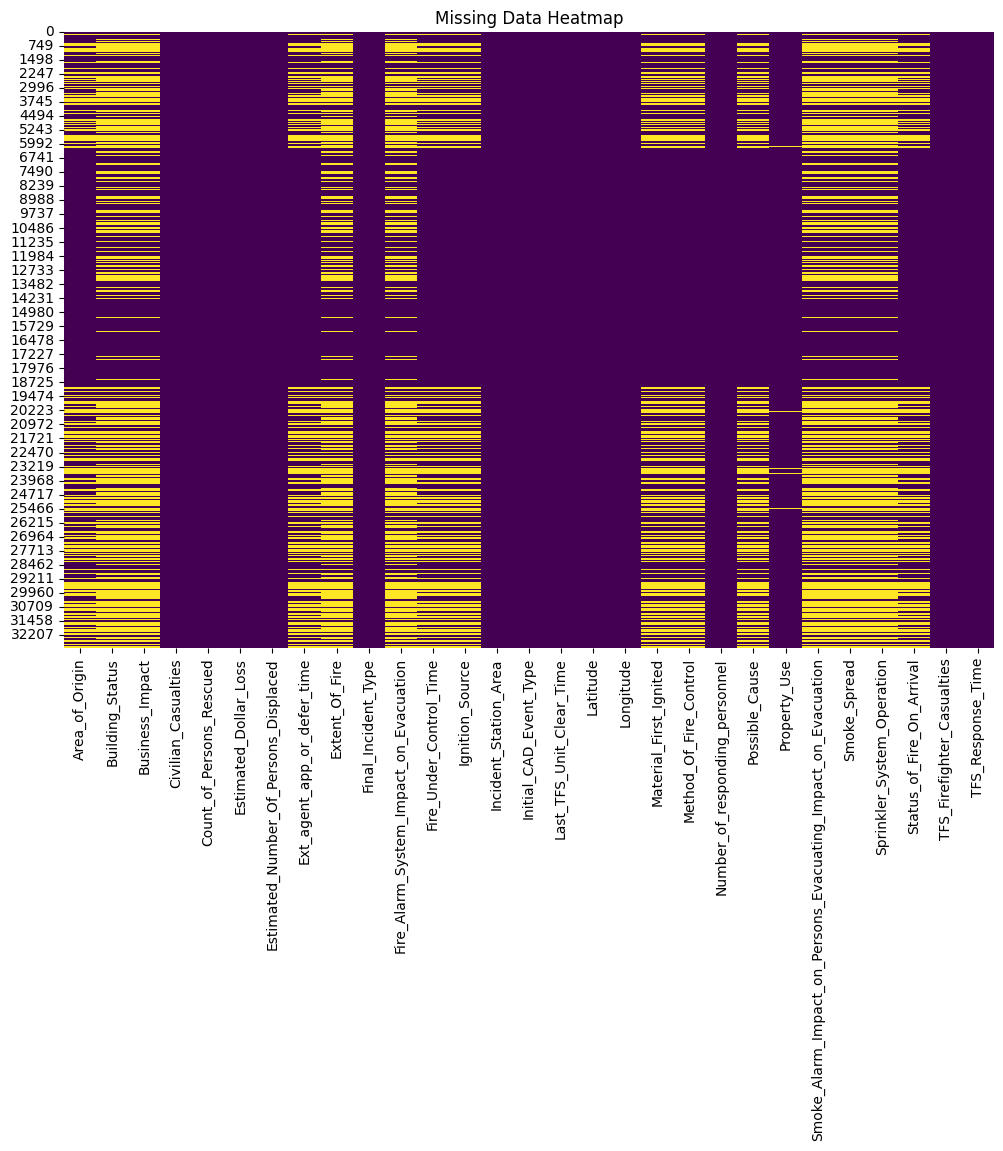

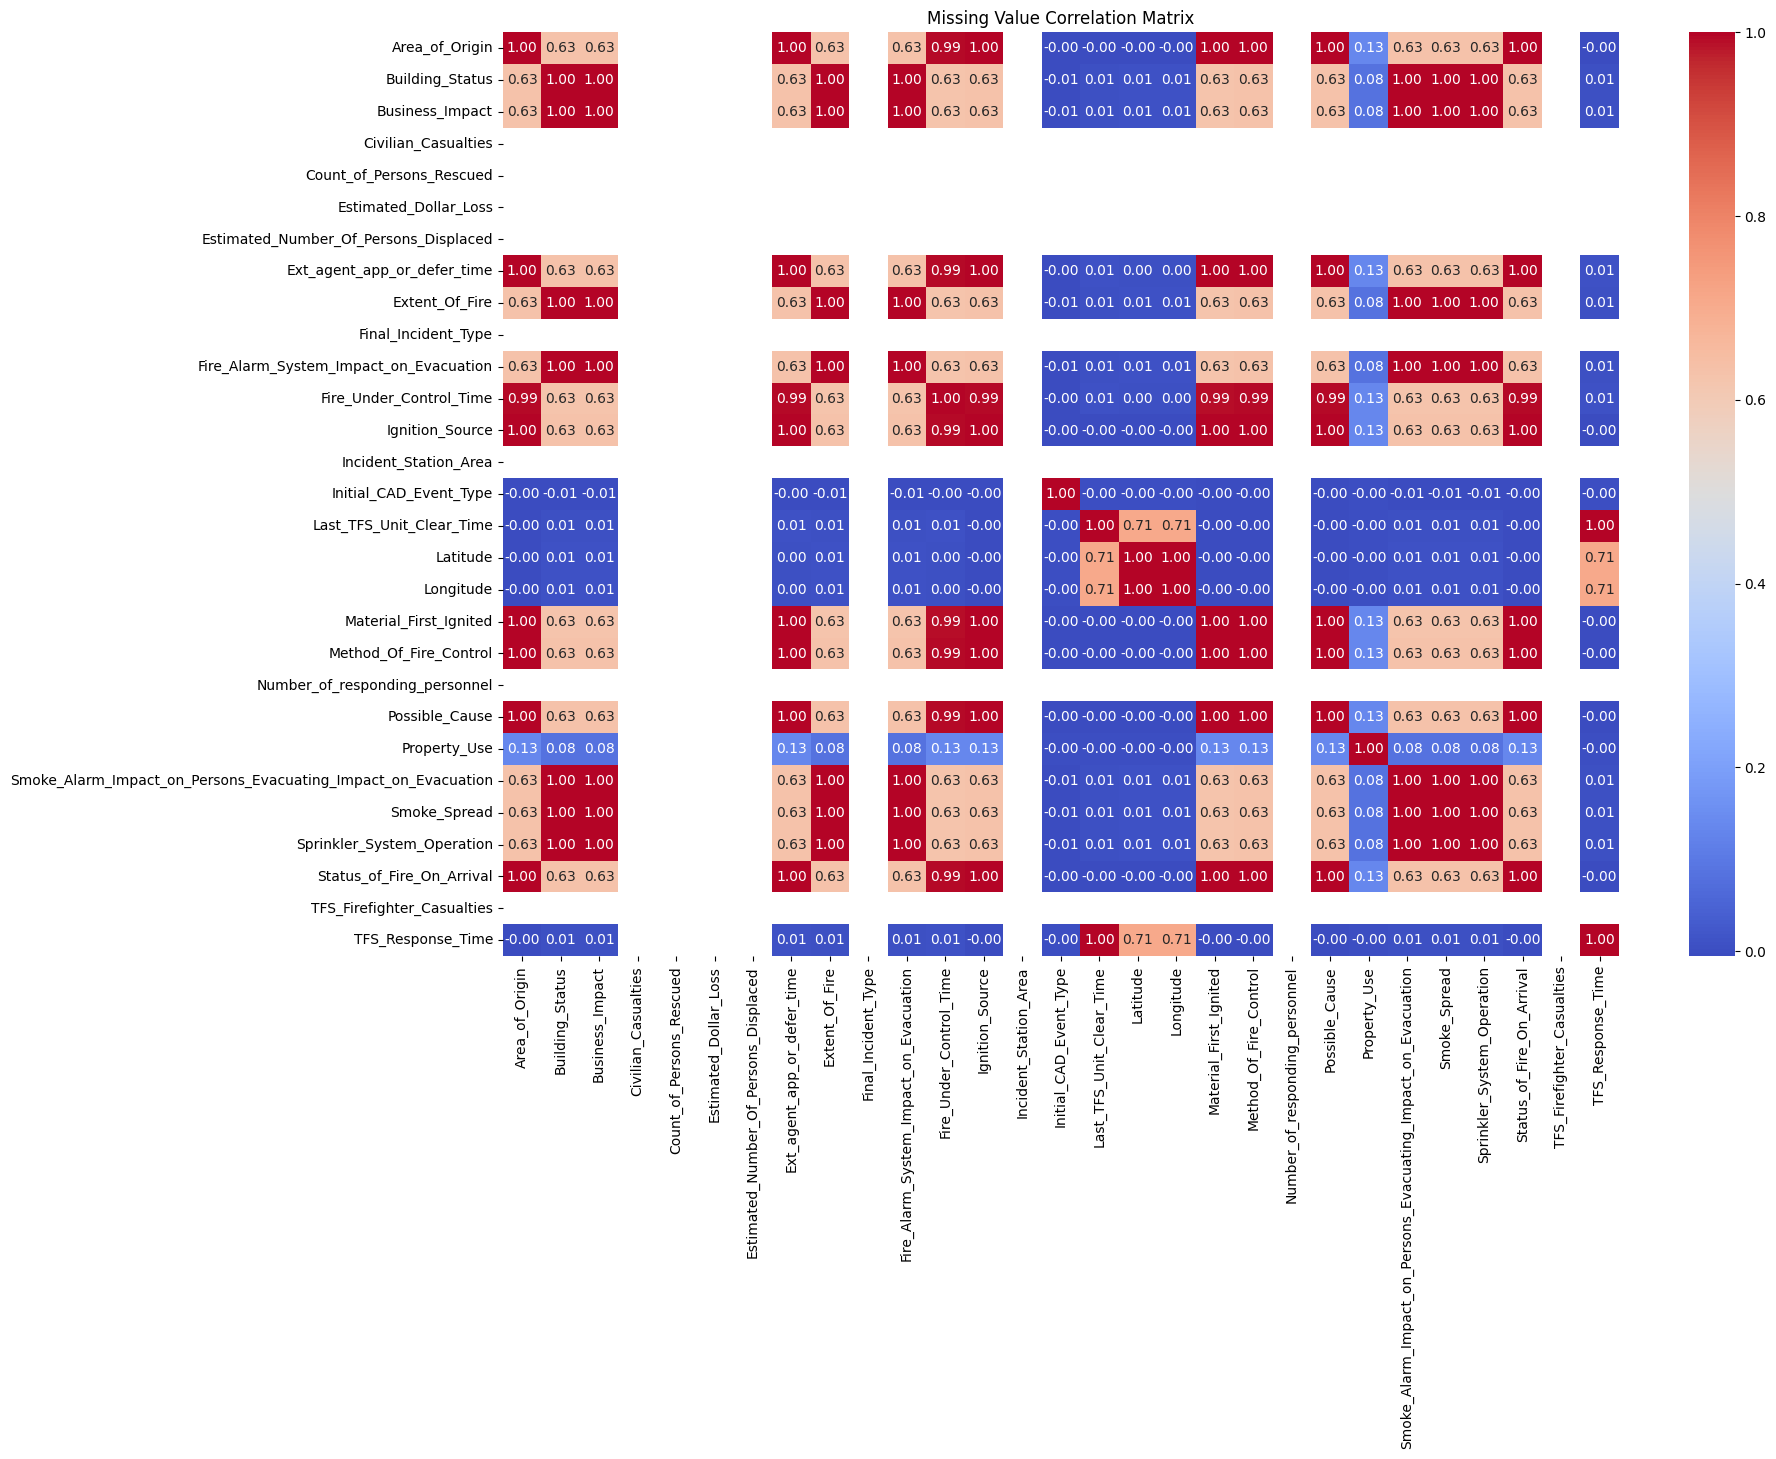

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#heatmap to visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(data_dropped.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

#missingness correlation matrix
missing_corr = data_dropped.isnull().corr()
plt.figure(figsize=(18, 12))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Missing Value Correlation Matrix')
plt.show()

## 2.2 Imputations! (MICE + KNN)

### Prepare the data for imputation

In [8]:
from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Step 1: Separate datetime columns and exclude from imputation
datetime_columns = data_dropped.select_dtypes(include=['datetime64']).columns
data_no_datetime = data_dropped.drop(columns=datetime_columns)

# Step 2: Separate column types
numerical_cols = data_no_datetime.select_dtypes(include=['float64']).columns
integer_cols = data_no_datetime.select_dtypes(include=['int64']).columns
categorical_cols = data_no_datetime.select_dtypes(include=['object']).columns

# Step 3: One-hot encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=True)
categorical_encoded = encoder.fit_transform(data_no_datetime[categorical_cols]).toarray()
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Step 4: Combine all columns for imputation
combined_data = pd.concat([data_no_datetime[numerical_cols], data_no_datetime[integer_cols], categorical_encoded_df], axis=1)

### MICE Imputation

### NOTE: ISSUE HERE! My kernal keeps crushing trying to run MICE Imputation. I suspect the issuse is the dataset is too big. Please try uncomment the code below and running it on your laptop!!!!!!

In [9]:
# # Apply MICE (IterativeImputer) imputation
# mice_imputer = IterativeImputer(max_iter=10, random_state=0)
# imputed_data = pd.DataFrame(mice_imputer.fit_transform(combined_data), columns=combined_data.columns)

# # Round integer columns
# imputed_data[integer_cols] = imputed_data[integer_cols].round().astype(int)

# # Decode categorical columns and reassemble final data
# imputed_categorical = pd.DataFrame(encoder.inverse_transform(imputed_data[categorical_encoded_df.columns]), columns=categorical_cols)
# data_final = pd.concat([imputed_data[numerical_cols], imputed_data[integer_cols], imputed_categorical], axis=1)

# # Reattach datetime columns and reorder
# data_final[datetime_columns] = data_dropped[datetime_columns]
# data_final = data_final[data_dropped.columns]

# data_final

### YOU CAN TEST IF YOUR LAPTOP RUNS THE CODE WITH 10% OF THE DATA

In [10]:
# sample_data = combined_data.sample(frac=0.1, random_state=1)  # Use 10% for quick testing

# mice_imputer = IterativeImputer(max_iter=10, random_state=0)
# imputed_data = pd.DataFrame(mice_imputer.fit_transform(sample_data), columns=sample_data.columns)

### KNN Imputation (K=40)

### NOTE: SAME ISSUE HERE! KNN Imputation crushes my kernal, so please try uncomment the code below and see if it runs on your laptop!

In [14]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Combine all columns for imputation and apply MinMax scaling
scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(combined_data), columns=combined_data.columns)

# KNN imputation
imputed_scaled_data = pd.DataFrame(KNNImputer(n_neighbors=40).fit_transform(scaled_data), columns=scaled_data.columns)

# Inverse scaling and round integer columns
imputed_data = pd.DataFrame(MinMaxScaler().fit(combined_data).inverse_transform(imputed_scaled_data), columns=scaled_data.columns)
imputed_data[integer_cols] = imputed_data[integer_cols].round().astype(int)

# Decode categorical columns and reassemble final data
imputed_categorical = pd.DataFrame(encoder.inverse_transform(imputed_data[categorical_encoded_df.columns]), columns=categorical_cols)
data_final = pd.concat([imputed_data[numerical_cols], imputed_data[integer_cols], imputed_categorical], axis=1)

# Reattach datetime columns and reorder
data_final[datetime_columns] = data_dropped[datetime_columns]
data_final = data_final[data_dropped.columns]

data_final

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,...,Method_Of_Fire_Control,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,TFS_Response_Time
0,81 - Engine Area,NaN,NaN,0,0,15000,0,2018-02-24T21:12:00,NaN,01 - Fire,...,1 - Extinguished by fire department,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",0,342.0
1,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50,0,2018-02-24T21:29:42,NaN,01 - Fire,...,1 - Extinguished by fire department,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,2 - Fire with no evidence from street,0,288.0
2,NaN,NaN,NaN,0,0,0,0,NaN,NaN,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",...,NaN,22,NaN,891 - Outdoor general auto parking,NaN,NaN,NaN,NaN,0,410.0
3,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0,0,0,0,2018-02-25T14:19:25,1 - Confined to object of origin,01 - Fire,...,1 - Extinguished by fire department,22,99 - Undetermined,511 - Department Store,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,3 - Fire with smoke showing only - including v...,0,268.0
4,NaN,NaN,NaN,0,0,0,0,NaN,NaN,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",...,NaN,22,NaN,860 - Lawn around structure,NaN,NaN,NaN,NaN,0,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32924,22 - Sleeping Area or Bedroom (inc. patients r...,01 - Normal (no change),1 - No business interruption,0,0,0,0,2023-01-01T07:29:02,1 - Confined to object of origin,01 - Fire,...,3 - Extinguished by occupant,37,Misuse of ignition source/material ignited,231 - Shelter for displaced/abused persons,3 - No one (at risk) evacuated as a result of ...,3 - Spread to entire room of origin,4 - Other reason for non activation/operation,1 - Fire extinguished prior to arrival,0,312.0
32925,64 - Porch or Balcony,01 - Normal (no change),8 - Not applicable (not a business),0,0,3000,0,2023-01-01T10:57:07,1 - Confined to object of origin,01 - Fire,...,1 - Extinguished by fire department,38,Other Unintended Cause,323 - Multi-Unit Dwelling Over 12 Units,7 - Not applicable: Occupant(s) first alerted ...,9 - Confined to roof/exterior structure,8 - Not applicable - no sprinkler system present,4 - Flames showing from small area (one storey...,0,207.0
32926,24 - Cooking Area or Kitchen,01 - Normal (no change),8 - Not applicable (not a business),0,0,1000,0,2023-01-01T12:28:05,1 - Confined to object of origin,01 - Fire,...,3 - Extinguished by occupant,28,Design/Construction/Maintenance deficiency,301 - Detached Dwelling,2 - Some persons (at risk) self evacuated as a...,"4 - Spread beyond room of origin, same floor",8 - Not applicable - no sprinkler system present,1 - Fire extinguished prior to arrival,0,290.0
32927,99 - Undetermined (formerly 98),NaN,NaN,0,0,5000,0,2023-01-01T13:17:38,NaN,01 - Fire,...,1 - Extinguished by fire department,13,Other Unintended Cause,839 - Tent or temporary structure not classifi...,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,0,377.0


### YOU CAN TEST IF YOUR LAPTOP RUNS THE CODE WITH 10% OF THE DATA

In [12]:
# scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(combined_data), columns=combined_data.columns)
# sample_data = scaled_data.sample(frac=0.1, random_state=1)  # Use 10% for quick testing

# # KNN imputation
# imputed_scaled_data = pd.DataFrame(KNNImputer(n_neighbors=1).fit_transform(sample_data), columns=scaled_data.columns)

In [15]:
#import the cleaned dataset as a csv file
from IPython.display import FileLink
data_final.to_csv('/Fire_Incidents_Data_Imputed.csv', index=False)  # index=False to avoid saving row indices
FileLink('Fire_Incidents_Data_Imputed.csv')

/content/Fire_Incidents_Data_Imputed.csv